# Introduction
This python notebook will be used for testing out the NZN parameter sets

## Importing functions and parameter sets

# Surrogate Model

In [1]:
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, LeakyReLU


import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
inputs = pd.read_pickle('overall_inputs_large_run3.p')
results_EUI = pd.read_pickle('overall_results_large_run3.p')

## One Hot Encoding
We need to convert our categorical values in one-hot encoded columns for non-ordinal ML training.

In [3]:
inputs_onehot=pd.get_dummies(inputs)

## Train-Test Split
We'll do 80/20 train/test split here

In [4]:
train_in, test_in, train_out, test_out = train_test_split(inputs_onehot, results_EUI, test_size=0.2)

## Normalization of inputs/outputs

In [5]:
scaler_in = StandardScaler()
NN_inputs = scaler_in.fit_transform(X=train_in)
NN_inputs_test=scaler_in.transform(X=test_in)

scaler_out = StandardScaler()#PowerTransformer(method='box-cox')
NN_outputs = scaler_out.fit_transform(X=train_out)
NN_outputs_test=scaler_out.transform(X=test_out)

## Build the Model
Using the keras functional API, we will build a relatively simple deep neural network

In [6]:
#This matches the number of parameter inputs we have to enter as the input layer into the NN
num_inputs = len(inputs_onehot.columns)
print(f'Number of inputs: {num_inputs}')
#This matches the number of model outputs we have to enter as the output layer into the NN
num_outputs = len(results_EUI.columns)
print(f'Number of inputs: {num_outputs}')

Number of inputs: 98
Number of inputs: 21


In [7]:
#Create a 4-layer model, with 2 middle layers both with nodes that are 16*the number of inputs
#The hidden layers are activated with ReLU function.
# Since we are performing regression we do not want an activation for the output. 
#The output has been normalized to 0 +/- 1 std, and a ReLU activation function only returns positive numbers.
#We will use an L2 regularizer to help prevent overfitting. For now we will use the default alpha 0.01.

input_layer = keras.Input(shape=(num_inputs,))

#first hidden layer
dense_1 = layers.Dense(units=num_inputs*5, kernel_regularizer='l2')(input_layer)
activation_1=layers.LeakyReLU()(dense_1)
#second hidden layer
dense_2 = layers.Dense(units=num_inputs*5, kernel_regularizer='l2')(activation_1)
activation_2=layers.LeakyReLU()(dense_2)
#third hidden layer
dense_3 = layers.Dense(units=num_inputs*5, kernel_regularizer='l2')(activation_2)
activation_3=layers.LeakyReLU()(dense_3)


#output layer
output_layer = layers.Dense(units=num_outputs)(activation_3)

model=models.Model(inputs=input_layer,outputs=output_layer)

In [8]:
print(model.summary())
# plot_model(model)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 98)]              0         
_________________________________________________________________
dense (Dense)                (None, 490)               48510     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 490)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 490)               240590    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 490)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 490)               240590    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 490)               0     

## Hyper-parameters

Before we start fitting the NN model we define the set of hyperparameters we want to analyse in our cross-validation to optimize the model.  
Here, we select the number of layers of the network as well as the regularization parameter alpha as parameter value.  
A larger number of layers and a lower value of the regularizer lead to higher variance of the network.  
This may lead to overfitting.  
The best selection may be found using an optimizer like Bayesian Optimization.  
In this example we use a simple grid search.

## Training

Here we will compile and train the model.

In [9]:
loss = 'mean_squared_error'
optimizer = 'adam'
metrics=['mae', 'mse']

model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

In [10]:
history=model.fit( x=NN_inputs, y=NN_outputs, batch_size = 256,epochs=1000)
test_scores = model.evaluate(NN_inputs_test, NN_outputs_test, verbose=2)
print("Test MAE:", test_scores[0])
print("Test MSE:", test_scores[1])

Epoch 1/1000
31/31 [==============================] - 0s 6ms/step - loss: 7.9374 - mae: 0.4996 - mse: 0.7414
Epoch 2/1000
31/31 [==============================] - 0s 5ms/step - loss: 2.6264 - mae: 0.3864 - mse: 0.5546
Epoch 3/1000
31/31 [==============================] - 0s 5ms/step - loss: 1.1470 - mae: 0.3728 - mse: 0.5360
Epoch 4/1000
31/31 [==============================] - 0s 5ms/step - loss: 0.8010 - mae: 0.3645 - mse: 0.5264
Epoch 5/1000
31/31 [==============================] - 0s 5ms/step - loss: 0.7153 - mae: 0.3595 - mse: 0.5195
Epoch 6/1000
31/31 [==============================] - 0s 5ms/step - loss: 0.6872 - mae: 0.3557 - mse: 0.5175
Epoch 7/1000
31/31 [==============================] - 0s 5ms/step - loss: 0.6712 - mae: 0.3502 - mse: 0.5115
Epoch 8/1000
31/31 [==============================] - 0s 5ms/step - loss: 0.6621 - mae: 0.3473 - mse: 0.5097
Epoch 9/1000
31/31 [==============================] - 0s 5ms/step - loss: 0.6581 - mae: 0.3512 - mse: 0.5074
Epoch 10/1000
31/31

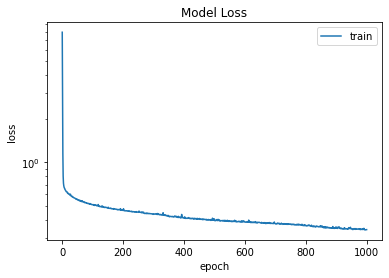

In [11]:
fig = plt.figure()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')

## Evaluate test set
Evaluate the test set using the NN and the actual values

In [12]:
train_eval=model.predict(NN_inputs)

In [13]:
train_eval=scaler_out.inverse_transform(train_eval)

In [14]:
train_eval_df=pd.DataFrame(train_eval,columns=results_EUI.columns)

In [15]:
test_eval=model.predict(NN_inputs_test)
test_eval=scaler_out.inverse_transform(test_eval)
test_eval_df=pd.DataFrame(test_eval,columns=results_EUI.columns)

In [16]:
mask = test_eval_df.isnull().values.sum(axis=1)==1
print(mask.sum())

0


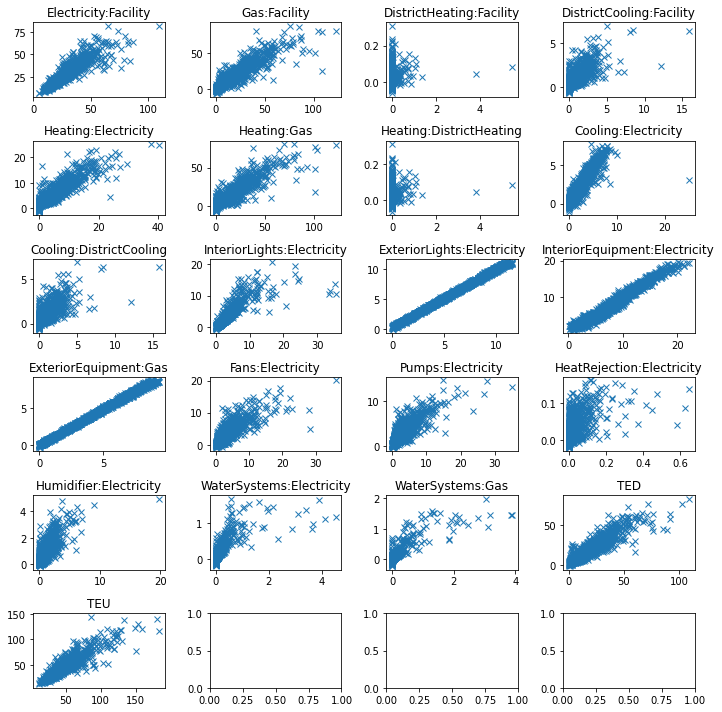

In [17]:
_,ax = plt.subplots(6,4, figsize=(10,10))
ax_flat = []
[ax_flat.append(i) for j in ax for i in j]
for i in range(num_outputs):
    ax_flat[i].plot(test_out.iloc[:,i], test_eval_df.iloc[:,i],'x')
    ax_flat[i].set_title(results_EUI.columns[i])
plt.tight_layout()

[0.8256377  0.83296202 0.00665446 0.58233837 0.84252148 0.82922895
 0.00661288 0.81492132 0.58234504 0.69901885 0.99483524 0.95606882
 0.99243209 0.6664209  0.67458531 0.33551307 0.57100296 0.54717053
 0.68992453 0.81528243 0.8207757 ]



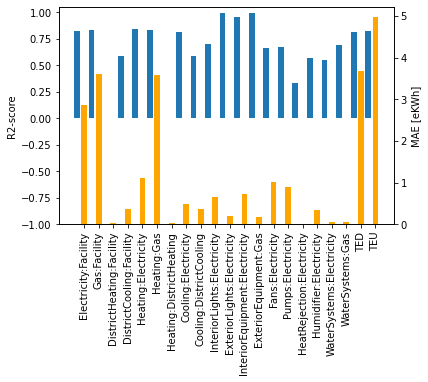

In [18]:
plt.bar(range(0,num_outputs*2,2),r2_score(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'))
plt.ylim([-1,1.05])
ax = plt.gca()
ax2=ax.twinx()

ax2.bar(range(1,num_outputs*2,2),
        mean_absolute_error(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'),
       color='orange')

ax.set_xticks(range(1,num_outputs*2,2))
_=ax.set_xticklabels(results_EUI.columns, rotation=90)
ax.set_ylabel('R2-score')
ax2.set_ylabel('MAE [eKWh]')
plt.grid=False
print(r2_score(test_out.values[:,:], test_eval_df.values[:,:], multioutput='raw_values'))
print()

In [21]:
# pickle the model:
import pickle
pickle.dump([inputs_onehot.columns, metadata, results_EUI.columns, scaler_in, scaler_out, inputs_onehot, results_EUI], open('model_pickle','wb'))

NameError: name 'metadata' is not defined

In [19]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [20]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,'model_new')

/usr/local/lib/python3.7/dist-packages/tensorflowjs/converters/keras_h5_conversion.py:122: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


# Optional: train one XGBoost surrogate per output

In [284]:
def build_model(num_outputs=1):
    input_layer = keras.Input(shape=(num_inputs,))

    #first hidden layer
    dense_1 = layers.Dense(units=num_inputs*4, kernel_regularizer='l2')(input_layer)
    activation_1=layers.LeakyReLU()(dense_1)
    #second hidden layer
    dense_2 = layers.Dense(units=num_inputs*4, kernel_regularizer='l2')(activation_1)
    activation_2=layers.LeakyReLU()(dense_2)
    #third hidden layer
    dense_3 = layers.Dense(units=num_inputs*4, kernel_regularizer='l2')(activation_2)
    activation_3=layers.LeakyReLU()(dense_3)


    #output layer
    output_layer = layers.Dense(units=num_outputs)(activation_3)

    model = models.Model(inputs=input_layer,outputs=output_layer)
    return model

In [64]:
import xgboost
scores = []
for n,out in enumerate(train_out.columns):
    model = xgboost.XGBRegressor()
    
    scaler_out = MinMaxScaler()#PowerTransformer(method='box-cox')
    NN_outputs = scaler_out.fit_transform(X=train_out.iloc[:,n].values.reshape(-1,1))
    NN_outputs_test=scaler_out.transform(X=test_out.iloc[:,n].values.reshape(-1,1))
    
    history=model.fit(NN_inputs, NN_outputs)
    test_eval=model.predict(NN_inputs_test)
    test_eval=scaler_out.inverse_transform(test_eval.reshape(-1,1))
    test_eval_df=pd.DataFrame(test_eval,columns=[results_EUI.columns[n]])
    
    scores.append(r2_score(test_out.loc[:,out], test_eval_df))

[0.78617825 0.83387989 0.09331597 0.67411632 0.83769921 0.82422485
 0.09331597 0.89004922 0.67411632 0.97717711 0.99824878 0.99328242
 0.99754358 0.71713287 0.69852827 0.33540745 0.6654652  0.98365275
 0.97779788 0.81910355 0.78224511]


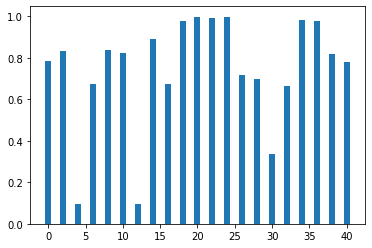

In [67]:
import numpy as np
plt.bar(range(0,len(train_out.columns)*2,2),scores)
print(np.array(scores).round(8))

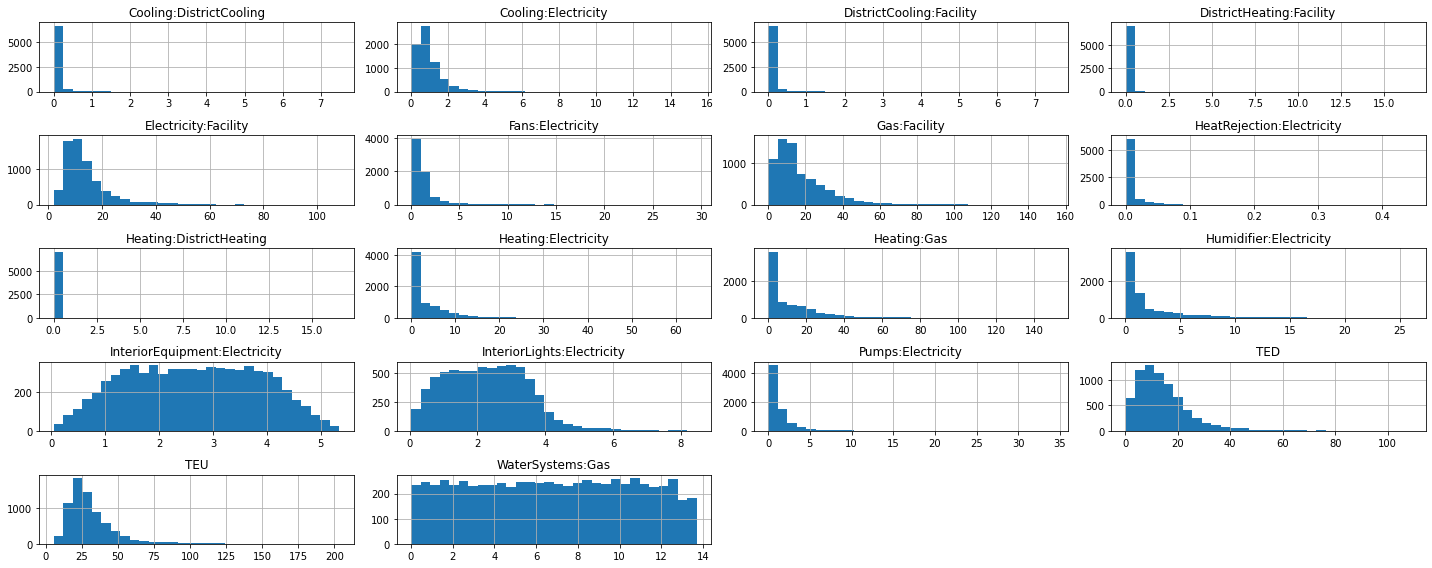

In [326]:
_=train_out.hist(figsize=(20,8), bins=30)
plt.tight_layout()